In [28]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import os
import random

In [29]:
# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Set seed for reproducibility
set_seed(42)

# Set deterministic operations in TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [30]:
train_x = []
train_y = []
r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0;
win_size = 33 # actual window size
win_size_kernel = int(win_size/2 + 1)


# define universe of possible input values
alphabet = 'ARNDCQEGHILKMFPSTWYV-'

# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# TRAIN DATASET -------------------------------------------------------------
#for positive sequence
def inner1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(posit_1)
for seq_record in SeqIO.parse("../data/train/fasta/positive_sites.fasta", "fasta"): # training data positive
    inner1()
#for negative sequence
def inner2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(negat_0)
for seq_record in SeqIO.parse("../data/train/fasta/negative_sites.fasta", "fasta"): # training data negative
    inner2()
# Changing to array (matrix)    
train_x = np.array(train_x)
train_y = np.array(train_y)


#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("../data/test/fasta/test_positive_sites.fasta", "fasta"): # test positive
    innertest1()
#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(negat_0)
for seq_record in SeqIO.parse("../data/test/fasta/test_negative_sites.fasta", "fasta"): # test negative
    innertest2()

r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)


# epochs = 100
# num_classes = 2
# batch_size = 256
# optimize_2 = tf.keras.optimizers.Adam()

# loss_2 = tf.keras.losses.binary_crossentropy

# test_size = 0.2
seed = 3

X_train = train_x
y_train = train_y

X_test = r_test_x
y_test = r_test_y


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(9499, 33)
(9499,)
(3226, 33)
(3226,)


In [31]:
train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]


# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])

# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_train_pt5 = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test_pt5 = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# # shuffle X and y together
# X_train_pt5, y_train_pt5 = shuffle(X_train_pt5, y_train_pt5)
# X_test_pt5, y_test_pt5 = shuffle(X_test_pt5, y_test_pt5)
print(X_train_pt5.shape)
print(y_train_pt5.shape)
print(X_test_pt5.shape)
print(y_test_pt5.shape)

(9499, 1024)
(9499,)
(3226, 1024)
(3226,)


In [32]:
from sklearn.model_selection import train_test_split

# Define the split ratio and random state for reproducibility
split_ratio = 0.1
random_state = 42

# Perform the split on the smaller dataset (X_train_pt5, y_train_pt5)
X_train_pt5, X_val_pt5, y_train_pt5, y_val_pt5 = train_test_split(
    X_train_pt5, y_train_pt5, test_size=split_ratio, random_state=random_state, stratify=y_train_pt5)

# Use the same indices to split the larger dataset (X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=split_ratio, random_state=random_state, stratify=y_train)

# Now, both X_val_pt5 and X_val correspond to the same split in y_train_pt5 and y_train
print( y_val[:10])
print( y_val_pt5[:10])

# X_test = X_test[:2000]
# y_test = y_test[:2000]
# X_test_pt5 = X_test_pt5[:2000]
# y_test_pt5 = y_test_pt5[:2000]

[0 0 0 1 1 0 0 1 1 1]
[0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]


In [33]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [34]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, y_val=None):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, precision, recall, specificity, f1

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 33, 21)    │      5,376 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 33, 21, 1) │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 17, 19,    │      1,664 │ lambda_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 17, 19,    │          0 │ conv2d_4[0][0]    │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 9, 32)  │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │    262,400 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2304)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 16)        │     36,880 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 16)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 144)       │          0 │ dropout_17[0][0], │
│ (Concatenate)       │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 16)        │      2,320 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 4)         │         68 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1)         │          5 │ dense_27[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 341,609 (1.30 MB)

 Trainable params: 341,609 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5046 - loss: 0.6941 - val_accuracy: 0.5621 - val_loss: 0.6900
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5522 - loss: 0.6853 - val_accuracy: 0.5989 - val_loss: 0.6800
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5638 - loss: 0.6729 - val_accuracy: 0.6168 - val_loss: 0.6642
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5901 - loss: 0.6590 - val_accuracy: 0.6684 - val_loss: 0.6509
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6423 - loss: 0.6421 - val_accuracy: 0.6758 - val_loss: 0.6370
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6599 - loss: 0.6295 - val_accuracy: 0.6916 - val_loss: 0.6199
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6852 - loss: 0.6099 - val_accuracy: 0.6926 - val_loss: 0.6027
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6931 - loss: 0.5972 - val_accuracy: 0.

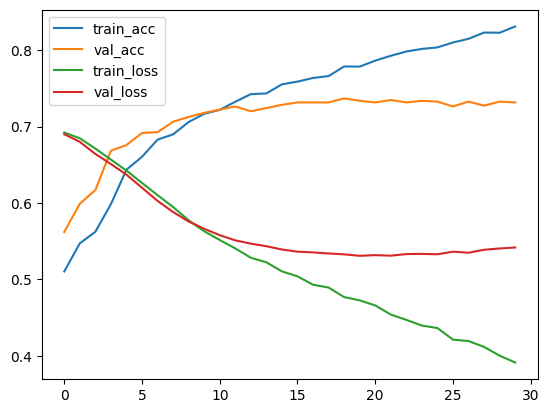

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7336842105263158
MCC: 0.4680170937049201
AUC: 0.7336842105263158
Precision: 0.722
Recall: 0.76
Specificity: 0.7073684210526315
F1: 0.7405128205128205
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7021078735275883
MCC: 0.27463426723899376
AUC: 0.7425492143387988
Precision: 0.18050541516245489
Recall: 0.7905138339920948
Specificity: 0.6945845946855028
F1: 0.29390154298310067


(0.7021078735275883,
 0.27463426723899376,
 0.7425492143387988,
 0.18050541516245489,
 0.7905138339920948,
 0.6945845946855028,
 0.29390154298310067)

In [17]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def LMSuccSite(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=256, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    x_conv = Lambda(lambda x: tf.expand_dims(x, 3))(x_conv)

    # Convolutional layers
    x_conv = Conv2D(32, kernel_size=(17, 3), activation='relu'
                    , kernel_initializer='he_normal', padding = 'VALID')(x_conv)
    x_conv = Dropout(0.2)(x_conv)
    x_conv = MaxPooling2D(pool_size=(2,2))(x_conv)
    x_conv = Flatten()(x_conv)

    x_conv = Dense(16, activation='relu', kernel_initializer='he_normal')(x_conv)
    x_conv = Dropout(0.2)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features with integer output
    x_ann = Dense(256, activation='relu')(ann_input)
    x_ann = Dropout(0.4)(x_ann)
    x_ann = Dense(128, activation='relu')(x_ann) 
    x_ann = Dropout(0.4)(x_ann)


    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Simple Dense layer for combined features
    x = Dense(16, activation='relu')(combined)
    # x = Dropout(0.2)(x)
    x = Dense(4, activation='relu')(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
LMSuccSite = LMSuccSite((33,), 1024)
LMSuccSite.summary()

# Fit the simple model
history = LMSuccSite.fit([X_train, X_train_pt5], y_train, epochs=100, batch_size=256,
                                 verbose=1, 
                                 validation_data=([X_val, X_val_pt5], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
                                )

plot(history)

# simple_model.load_weights('models/simple_model.weights.h5')

# Evaluate the model
evaluate_model(LMSuccSite, X_val, X_val_pt5, y_val)
evaluate_model(LMSuccSite, X_test, X_test_pt5, y_test)




In [36]:
from keras.layers import Input, Embedding, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def create_conv_branch(input_shape_conv):
    conv_input = Input(shape=input_shape_conv, name='conv_input')

    # Embedding layer
    x = Embedding(input_dim=256, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    x = Lambda(lambda x: tf.expand_dims(x, 3))(x)

    # Convolutional layers
    x = Conv2D(32, kernel_size=(17, 3), activation='relu',
               kernel_initializer='he_normal', padding='VALID')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.2)(x)

    # Output of convolutional branch
    conv_output = Dense(16, activation='relu', name='conv_output')(x)

    conv_output = Dense(1, activation='sigmoid')(conv_output)

    model = Model(inputs=conv_input, outputs=conv_output, name='conv_branch')

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model
# Instantiate the convolutional branch
conv_branch = create_conv_branch((33,))

# Train the convolutional branch
conv_history = conv_branch.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Optionally, save the trained weights
conv_branch.save_weights('conv_branch.weights.h5')


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5024 - loss: 0.6932 - val_accuracy: 0.6179 - val_loss: 0.6887
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5735 - loss: 0.6858 - val_accuracy: 0.6063 - val_loss: 0.6693
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5993 - loss: 0.6644 - val_accuracy: 0.6474 - val_loss: 0.6315
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6365 - loss: 0.6392 - val_accuracy: 0.6747 - val_loss: 0.6116
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6720 - loss: 0.6090 - val_accuracy: 0.6811 - val_loss: 0.6076
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6787 - loss: 0.6001 - val_accuracy: 0.7011 - val_loss: 0.5862
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7078 - loss: 0.5787 - val_accuracy: 0.6968 - val_loss: 0.5802
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7100 - loss: 0.5678 - val_accuracy: 0.

In [37]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def create_ann_branch(input_shape_ann):
    ann_input = Input(shape=(input_shape_ann,), name='ann_input')

    x = Dense(256, activation='relu')(ann_input)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Output of ANN branch
    ann_output = Dense(1, activation='sigmoid', name='ann_output')(x)

    model = Model(inputs=ann_input, outputs=ann_output, name='ann_branch')

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Instantiate the ANN branch
ann_branch = create_ann_branch(1024)

# Train the ANN branch
ann_history = ann_branch.fit(
    X_train_pt5, y_train,
    epochs=100,
    batch_size=256,
    verbose=1,
    validation_data=(X_val_pt5, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Optionally, save the trained weights
ann_branch.save_weights('ann_branch.weights.h5')


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5775 - loss: 0.6634 - val_accuracy: 0.7116 - val_loss: 0.5806
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7156 - loss: 0.5594 - val_accuracy: 0.7221 - val_loss: 0.5490
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7482 - loss: 0.5085 - val_accuracy: 0.7232 - val_loss: 0.5468
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7719 - loss: 0.4735 - val_accuracy: 0.7221 - val_loss: 0.5483
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7967 - loss: 0.4368 - val_accuracy: 0.7232 - val_loss: 0.5662
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8274 - loss: 0.3837 - val_accuracy: 0.7105 - val_loss: 0.6021
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8607 - loss: 0.3354 - val_accuracy: 0.7168 - val_loss: 0.6415
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8830 - loss: 0.2838 - val_accuracy: 0.7316 - 

In [38]:
from keras.layers import Concatenate, Dense
from keras.models import Model

def create_combined_model(conv_branch, ann_branch):
    # Freeze the branches if you don't want to train them initially
    conv_branch.trainable = False
    ann_branch.trainable = False

    # Define inputs
    conv_input = conv_branch.input
    ann_input = ann_branch.input

    # Get outputs from the branches
    conv_output = conv_branch.get_layer(index=6).output
    ann_output = ann_branch.get_layer(index=4).output

    # Concatenate the outputs
    combined = Concatenate()([conv_output, ann_output])

    # Add combined layers
    x = Dense(16, activation='relu')(combined)
    x = Dense(4, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    # Define the combined model
    combined_model = Model(inputs=[conv_input, ann_input], outputs=output, name='combined_model')

    # Compile the combined model
    combined_model.compile(optimizer=Adam(learning_rate=0.001),
                           loss=BinaryCrossentropy(),
                           metrics=['accuracy'])

    return combined_model

# If you saved the weights separately, load them
conv_branch.load_weights('conv_branch.weights.h5')
ann_branch.load_weights('ann_branch.weights.h5')

# Create the combined model
combined_model = create_combined_model(conv_branch, ann_branch)

# View the summary
combined_model.summary()

# Train the combined model
combined_history = combined_model.fit(
    [X_train, X_train_pt5], y_train,
    epochs=100,
    batch_size=256,
    verbose=1,
    validation_data=([X_val, X_val_pt5], y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


# Evaluate the model
evaluate_model(combined_model, X_val, X_val_pt5, y_val)
evaluate_model(combined_model, X_test, X_test_pt5, y_test)




Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv_input          │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 33, 21)    │      5,376 │ conv_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 33, 21, 1) │          0 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ann_input           │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 17, 19,    │      1,664 │ lambda_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 256)       │    262,400 │ ann_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 17, 19,    │          0 │ conv2d_10[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 256)       │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 8, 9, 32)  │          0 │ dropout_36[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 128)       │     32,896 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 2304)      │          0 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ dense_51[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 2432)      │          0 │ flatten_9[0][0],  │
│ (Concatenate)       │                   │            │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 16)        │     38,928 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 4)         │         68 │ dense_52[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          5 │ dense_53[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 341,337 (1.30 MB)

 Trainable params: 39,001 (152.35 KB)

 Non-trainable params: 302,336 (1.15 MB)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6439 - loss: 0.6247 - val_accuracy: 0.7221 - val_loss: 0.5260
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7961 - loss: 0.4460 - val_accuracy: 0.7474 - val_loss: 0.5068
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8135 - loss: 0.4062 - val_accuracy: 0.7568 - val_loss: 0.5075
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8259 - loss: 0.3967 - val_accuracy: 0.7632 - val_loss: 0.5020
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8263 - loss: 0.3902 - val_accuracy: 0.7642 - val_loss: 0.4935
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8317 - loss: 0.3747 - val_accuracy: 0.7674 - val_loss: 0.4894
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8376 - loss: 0.3659 - val_accuracy: 0.7726 - val_loss: 0.4856
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8423 - loss: 0.3554 - val_accuracy: 0.

(0.7479851208927464,
 0.3280438638935064,
 0.7800966272207444,
 0.21252566735112938,
 0.8181818181818182,
 0.7420114362596704,
 0.3374083129584352)